**New York City Taxi Trip Duration**

This notebook goes through a simple process of extracting basic features, building a model and then make predictions.

I am using the TPOT package to create a pipeline. TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. I thought it is useful to add this to the list of kernels available in this competition.

**Objective:**

The challenge is to build a model that predicts the total ride duration of taxi trips in New York City. The primary data set is released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.
This challenge is a little different from most because kagglers are encouraged to publish additional training data that other participants can use for their predictions.

First things first, lets look at the data.

I borrowed some feature engineering codes from Nir Mabin's ["Dark Taxi - TripDurationPrediction"](https://www.kaggle.com/donniedarko/darktaxi-tripdurationprediction-lb-0-385)
and Beluga's ["From EDA to the Top"](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367).

**If this helped you, some up-votes would be very much appreciated - it would keep me motivated.**

In [1]:
# Import libraries
import os
mingw_path = 'g:/mingw64/bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from haversine import haversine
import datetime as dt

from subprocess import check_output
print(check_output(["ls", "../input/nyc-taxi-trip-duration"]).decode("utf8"))

sample_submission.csv
test.csv
train.csv



****Load the data****

In [2]:
# Load training data as train
#trainDF = pd.read_csv('../input/train.csv')
#Use the line above instead of the one below if not running on Kaggle i.e. running locally.
trainDF = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv', nrows=51000)

# Load testing data as test
testDF = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv')

# Print size as well as the top 5 observation of training dataset
print('Size of the training set is: {} rows and {} columns'.format(*trainDF.shape))
print ("\n", trainDF.head(5))

Size of the training set is: 51000 rows and 11 columns

           id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.76

We have only 11 columns but 1458644 rows which is a reasonable size. We also have two types of ids namely id and vendor_id. Lets try to understand this data.

NOTE:
This statement reflects if you load the whole training data. In order to be able to run the whole script on Kaggle, I had to load only 50,000 rows of the training data to show the notebook in action.

****Understanding Data****

In [3]:
# Look at the summary of numerical variables for train data set
df = trainDF.describe()
print (df)

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  51000.000000     51000.000000      51000.000000     51000.000000   
mean       1.529529         1.666922        -73.973495        40.751208   
std        0.499132         1.315837          0.037942         0.027973   
min        1.000000         1.000000        -74.393555        40.449749   
25%        1.000000         1.000000        -73.991776        40.737579   
50%        2.000000         1.000000        -73.981636        40.754436   
75%        2.000000         2.000000        -73.967087        40.768505   
max        2.000000         6.000000        -73.518051        41.091171   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       51000.000000      51000.000000   51000.000000  
mean          -73.973379         40.752004     949.162137  
std             0.036689          0.032522    3168.061719  
min           -74.398514         40.444698       1.000000  
25%           -73.991371

In [4]:
# Print the shape of the data
print("Train shape : ", trainDF.shape)
print("Test shape : ", testDF.shape)

Train shape :  (51000, 11)
Test shape :  (625134, 9)


**What are the data types ?**

In [5]:
dtypeDF = trainDF.dtypes.reset_index()
dtypeDF.columns = ["Count", "Column Type"]
dtypeDF.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3
1,float64,4
2,object,4


There are 3 integers, 4 floats and four categorical variables.

****Understanding distribution of target variable i.e trip duration.****

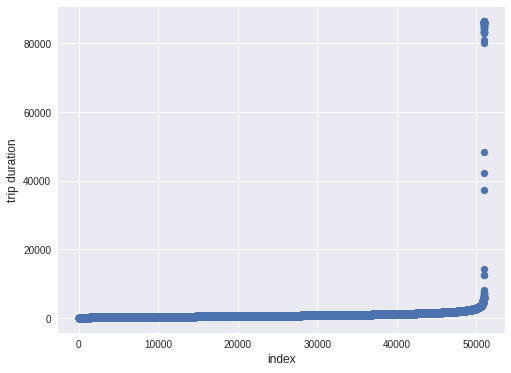

In [6]:
# Plot the trip duration
plt.figure(figsize=(8,6))
plt.scatter(range(trainDF.shape[0]), np.sort(trainDF.trip_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

We can see a few outliers with one way out there compared to the other 3 outliers. Lets remove those points so that we can zoom in.

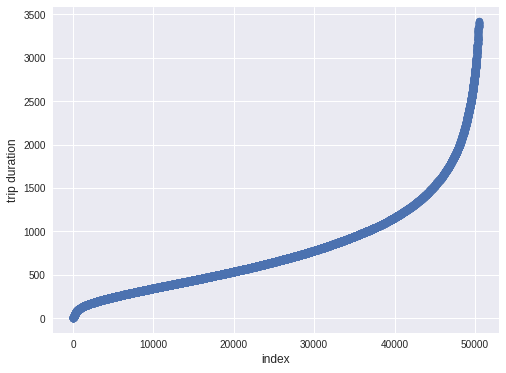

In [7]:
# in train dataset some trip duration are very high (I consider them outliers and remove them before replotting it)
th = trainDF.trip_duration.quantile(0.99)
tempDF = trainDF
tempDF = tempDF[tempDF['trip_duration'] < th]
plt.figure(figsize=(8,6))
plt.scatter(range(tempDF.shape[0]), np.sort(tempDF.trip_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

del tempDF

In [8]:
# Lets remove the outliers from the train data target
trainDF = trainDF[trainDF['trip_duration'] < th]

Dealing with missing values

In [9]:
# Number of variables with missing values
variables_missing_value = trainDF.isnull().sum()
variables_missing_value 

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Nice, there are no missing values in the training data. What about the test data?

In [10]:
variables_missing_value = testDF.isnull().sum()
variables_missing_value 

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

There are no missing values in the test data either. So lets get to the modelling bit and brew that tea for NYC.

First we have to do a quick data pre-processing and feature selection.

****Feature Generation****

Here we make a very simple data pre-processing and feature selection.

In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

t0 = dt.datetime.now()

train = trainDF
test = testDF
del trainDF, testDF

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

train['trip_duration'].describe()

train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

# Feature Extraction
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

# Distance
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

# Datetime features
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

train.loc[:,'week_delta'] = train['pickup_datetime'].dt.weekday + \
    ((train['pickup_datetime'].dt.hour + (train['pickup_datetime'].dt.minute / 60.0)) / 24.0)
test.loc[:,'week_delta'] = test['pickup_datetime'].dt.weekday + \
    ((test['pickup_datetime'].dt.hour + (test['pickup_datetime'].dt.minute / 60.0)) / 24.0)

# Make time features cyclic
train.loc[:,'week_delta_sin'] = np.sin((train['week_delta'] / 7) * np.pi)**2
train.loc[:,'hour_sin'] = np.sin((train['pickup_hour'] / 24) * np.pi)**2

test.loc[:,'week_delta_sin'] = np.sin((test['week_delta'] / 7) * np.pi)**2
test.loc[:,'hour_sin'] = np.sin((test['pickup_hour'] / 24) * np.pi)**2

# Speed
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

# Clustering
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
t1 = dt.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

# Temporal and geospatial aggregation
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

# For this particular problem we can add OSRM ([Open Source Routing Machine](http://project-osrm.org/ 
# "OSRM")) features. This data contains the fastest routes from specific starting points in NY.
fr1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('../input/new-york-city-taxi-with-osrm//fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')




Trip_duration and datetimes are ok.
Time till clustering: 30 seconds


In [12]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
#ytrain = np.log(train['trip_duration'].values + 1)
#ytrain = train[train['trip_duration'].notnull()]['trip_duration_log'].values


t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 62 features.
Feature extraction time: 73 seconds


****Feature check before modeling****

In [13]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
59,total_distance,0.032795
12,distance_dummy_manhattan,0.033257
11,distance_haversine,0.033549
14,pca_manhattan,0.033868
55,cnt_pickup_cluster_dropoff_cluster,0.040322


****Train a simple classifier****

We use the TPOT package to handle the cross validation and hyperparameters for us

In [14]:
from tpot import TPOTRegressor
auto_classifier = TPOTRegressor(generations=3, population_size=10, verbosity=2)
from sklearn.model_selection import train_test_split

**Split the training data to train and validate**

In [15]:
# K Fold Cross Validation
from sklearn.model_selection import KFold

X = train[feature_names].values
y = np.log(train['trip_duration'].values + 1)  


kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 5049  5050  5051 ..., 50487 50488 50489] TEST: [   0    1    2 ..., 5046 5047 5048]
TRAIN: [    0     1     2 ..., 50487 50488 50489] TEST: [ 5049  5050  5051 ..., 10095 10096 10097]
TRAIN: [    0     1     2 ..., 50487 50488 50489] TEST: [10098 10099 10100 ..., 15144 15145 15146]
TRAIN: [    0     1     2 ..., 50487 50488 50489] TEST: [15147 15148 15149 ..., 20193 20194 20195]
TRAIN: [    0     1     2 ..., 50487 50488 50489] TEST: [20196 20197 20198 ..., 25242 25243 25244]
TRAIN: [    0     1     2 ..., 50487 50488 50489] TEST: [25245 25246 25247 ..., 30291 30292 30293]
TRAIN: [    0     1     2 ..., 50487 50488 50489] TEST: [30294 30295 30296 ..., 35340 35341 35342]
TRAIN: [    0     1     2 ..., 50487 50488 50489] TEST: [35343 35344 35345 ..., 40389 40390 40391]
TRAIN: [    0     1     2 ..., 50487 50488 50489] TEST: [40392 40393 40394 ..., 45438 45439 45440]
TRAIN: [    0     1     2 ..., 45438 45439 45440] TEST: [45441

In [ ]:
auto_classifier.fit(X_train, y_train)

In [ ]:
print("The cross-validation MSE")
print(auto_classifier.score(X_valid, y_valid))

In [ ]:
# Now do the prediction
test_result = auto_classifier.predict(test[feature_names].values)
sub = pd.DataFrame()
sub['id'] = test['id']
sub['trip_duration'] = np.exp(test_result)
sub.to_csv('NYCTaxi_TpotModels.csv', index=False)
sub.head()

In [ ]:
# Export the model
auto_classifier.export('NYCTaxi_pipeline.py')

That is it for now. You can run locally with more number of generations, population, etc. to get a better result. Because of Kaggle time limitations I could not choose parameters that take longer to run.

I hope you like it. If so please up-vote. 

**Stay tuned !!!**